## Task 1
### Solving ordinary differential equation of the second order by finite difference method

Equation:<br/>
$ u''(x) + q(x) u'(x) + r(x) u(x) = f(x) $

x $ \in (a, b) $

Boundary values: <br/>
$ \alpha_{1}u(a) − \alpha_{2}u′(a) = \alpha, |\alpha_{1}| + |\alpha_{2}| \neq 0, \alpha_{1}\alpha_{2} ≥ 0, $ <br/>
$ \beta_{1}u(b) + \beta_{2}u′(b) = \beta, |\beta_{1}| + |\beta_{2}| \neq 0, \beta_{1}\beta_{2} ≥ 0. $


In [201]:
import numpy as np
from typing import Tuple, Callable
from math import e, sin, cos
from scipy.sparse import coo_matrix, vstack
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

Function = Callable[[float], float]
Grid = Tuple[np.ndarray, float]
BoundaryValue = Tuple[float, float, float]

#### Solves linear algebraic systems with tridiagonal matrix
Uses [tridiagonal matrix algorighm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)


In [202]:
def solve_tridiagonal_system(left_side: np.ndarray, right_side: np.ndarray) -> np.ndarray:
    return spsolve(left_side, right_side)
    alphas = []
    betas = []

    for i in range(left_side.shape[0]):
        y = left_side[i, i] if i == 0 else left_side[i, i] + left_side[i, i - 1] * alphas[i - 1]
        alphas.append(0 if i == (left_side.shape[0] - 1) else -1 * left_side[i, i + 1] / y)
        betas.append(right_side[i] / y if i == 0 else (right_side[i] - left_side[i, i - 1] * betas[i - 1]) / y)

    reversed_solution = []
    for i in reversed(range(left_side.shape[0])):
        reversed_solution.append(
            betas[i]
            if i == (left_side.shape[0] - 1) else
            alphas[i] * reversed_solution[left_side.shape[0] - i - 2] + betas[i]
        )
    return np.array(reversed_solution[::-1])

In [183]:
def get_true_error_norm(true_solution: np.ndarray, actual_solution: np.ndarray) -> float:
    return abs(true_solution - actual_solution).max()

In [188]:
def get_richardson_error_norm(current_solution: np.ndarray, next_solution: np.ndarray, r=2, p=2) -> float:
    n = len(current_solution)
    sum = 0
    [sum := sum + get_richardson_error(current_solution[i], next_solution[i * 2], r, p) for i in range(n)]
    return sum / n


def get_richardson_error(curent_solution, next_solution, r=2, p=2) -> float:
    return ((curent_solution - next_solution) / (r ** p - 1)) ** 2


def get_richardson_clarified_solution(current_solution, next_solution, r=2, p=2):
    n = len(next_solution)
    clarified_solution = np.zeros(n)
    errors = [0] * n
    for i in range(len(current_solution)):
        errors[i * 2] = get_richardson_error(current_solution[i], next_solution[i * 2], r, p)
    for i in range(len(current_solution) - 1):
        errors[i * 2 + 1] = (errors[i * 2] + errors[i * 2 + 2]) / 2
    errors[-1] = errors[-2]

    for i in range(n):
        clarified_solution[i] = next_solution[i] + errors[i]

    return clarified_solution

#### Transforms differential equation into an equal algebraic system

The method is based on replacing derivative with finite differences of $O(h^{2})$ order.
An approximated function is represented by values in points of the grid.

In [14]:
def solve_equation(
        q: Function,
        r: Function,
        f: Function,
        grid: Grid,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue
        ) -> np.ndarray:
    alpha_1, alpha_2, alpha = left_boundary_value
    beta_1, beta_2, beta = right_boundary_value

    points, step = grid

    first_row = [
        alpha_1 + 3 / (2 * step) * alpha_2,
        -2 * alpha_2 / step,
        alpha_2 / (2 * step),
    ]
    first_row.extend([0] * (len(points) - 3))

    left_side = coo_matrix([first_row])
    right_side = [alpha]

     ## Finite differences for inner points of the grid
    for index, point in enumerate(points[1:-1]):
        row = [0] * index

        row.append(1 / (step ** 2) - q(point) / (2 * step))
        row.append(-2 / (step ** 2) - r(point))
        row.append(1 / (step ** 2) + q(point) / (2 * step))

        row.extend([0] * (len(points) - index - 3))

        left_side = vstack([left_side, row])
        right_side.append(f(point))

    last_row = [float(0)] * (len(points) - 3)
    last_row.extend([
        beta_2 / (2 * step),
        -2 * beta_2 / step,
        beta_1 + 3 * beta_2 / (2 * step),
    ])

    left_side = vstack([left_side, last_row], format='lil')
    right_side.append(beta)

    return solve_tridiagonal_system(left_side, right_side)

    

In [178]:
def solve_equation_with_accuracy(
        a: float,
        b: float,
        q: Function,
        r: Function,
        f: Function,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue,
        epsilon: float) -> dict:
    grid_size = 4
    grid = np.linspace(a, b, grid_size, retstep=True)
    next_solution = solve_equation(q, r, f, grid, left_boundary_value, right_boundary_value)
    error = float("inf")
    grid_sizes = []
    errors = []
    while error >= epsilon:
        current_solution = next_solution
        grid_size *= 2
        grid = np.linspace(a, b, grid_size, retstep=True)
        next_solution = solve_equation(q, r, f, grid, left_boundary_value, right_boundary_value) 
        error =  get_richardson_error_norm(current_solution, next_solution)
        grid_sizes.append(grid_size)
        errors.append(error)
    clarified_solution = get_richardson_clarified_solution(current_solution, next_solution)
    
    result = {}
    result["clarified_solution"] = clarified_solution
    result["solution"] = next_solution
    result["grid"] = grid
    result["grid_sizes"] = grid_sizes
    result["errors"] = errors
    
    return result 

In [179]:
def run_test(q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u=None):
    result = solve_equation_with_accuracy(a, b, q, r, f, left_boundary_value, right_boundary_value, epsilon)
    points, step = result["grid"]
    
    if u is not None:
        true_solution = []
        for point in points:
            true_solution.append(u(point))
        true_error = get_true_error_norm(true_solution, result["solution"])

        print("Real Error: ", true_error)
    
    print("Last Error: ", result["errors"][-1])
    print("Last Grid Size: ", len(points))
    print("Last Step: ", step)

    plt.figure(figsize=(6, 3))
    plt.loglog(result["grid_sizes"], result["errors"], label='Errors', color='red')
    plt.xlabel('grid size')
    plt.ylabel('error norm')
    plt.grid()
    plt.title('Errors')
    plt.show()

### Test 1
#### Simple conditions

$ u = xe^{sin(x)} $ </br>
$ u(-2) = -2e^{sin(-2)} $ </br>
$ u(6) = 6e^{sin(6)} $

$ \varepsilon = 10^{-6} $

c:\Users\plosk\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Real Error:  2.5957564009360112e-06
Last Error:  6.498992257007092e-07
Last Grid Size:  4096
Last Step:  0.0019536019536019536


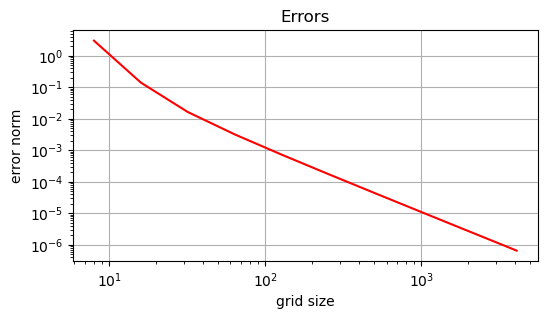

In [203]:
u = lambda x: x * e ** sin(x)
du = lambda x: e ** sin(x) * (x * cos(x) + 1)
ddu = lambda x: e ** sin(x) * (-x * sin(x) + x * cos(x) ** 2 + 2 * cos(x))

q = lambda x: -x
r = lambda x: 1
f = lambda x: ddu(x) + q(x) * du(x) - r(x) * u(x)

a = -2
b = 6

alpha_1 = 1
alpha_2 = 0
alpha = -2 * e ** sin(-2)

left_boundary_value = (alpha_1, alpha_2, alpha)

beta_1 = 1
beta_2 = 0
beta = 6 * e ** sin(6)

right_boundary_value = (beta_1, beta_2, beta)

epsilon = 1 / 1000000

run_test(q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u)


### Test 2
#### General conditions

$ u(x) = x^{5} - 5x^{4} + 5x^{3} + 5x^{2} - 6x $ </br>
$ 2u(-1) + 3u'(-1) = -24 $ </br>
$ 3u(3) + \frac{3}{8}u'(3) = 3 $

In [205]:


u = lambda x: x ** 5 - 5 * x ** 4 + 5 * x ** 3 + 5 * x ** 2 - 6 * x
du = lambda x: 5 * x ** 4 - 20 * x ** 3 + 15 * x ** 2 + 10 * x - 6
ddu = lambda x: 10 * (2 * x ** 3 - 6 * x ** 2 + 3 * x + 1)

q = lambda x: 5
r = lambda x: -x
f = lambda x: ddu(x) + q(x) * du(x) - r(x) * u(x)

a = -1
b = 3

alpha_1 = 2
alpha_2 = 1
alpha = -24

left_boundary_value = (alpha_1, alpha_2, alpha)

beta_1 = 3
beta_2 = 1 / 8
beta = 3

right_boundary_value = (beta_1, beta_2, beta)

epsilon = 1 / 1000000

run_test(q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u)

KeyboardInterrupt: 